# Monitoring german law publications in OpenAlex over time

# Table of content
* [Configure Notebook](#configure)
* [Intro](#Intro)
    * [General](#General)
    * [Specifications](#Specifications)
* [Version statistics](#version-statistics)
    * [versions covered](#versions-covered)
    * [items](#items)
    * [authors](#authors)
    * [references](#references)
    * [citations](#citations)
    * [affiliations](#affiliations)
    

Install and load JupySQL (https://jupysql.ploomber.io)

# <a id="configure"></a>Configure Notebook

In [1]:
%pip install jupysql python-dotenv --quiet
%load_ext sql
%config SqlMagic.displaylimit = 20
%load_ext autoreload
%pip install psycopg2-binary pandas matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Configure the sql adapter with your credentials. This requires an `.env` file having the following entries:
```
KB_HOST='<host name as as per KB instructions>'
KB_DB='<database name as per KB instructions>'
KB_PORT=<port as per KB instructions>
KB_USER='<Your user name>'
KB_PASS='<Your password>'
```

You also need to connect to the KB via VPN as per KB instructions.

In [2]:
from dotenv import load_dotenv
from sqlalchemy import URL, create_engine
import os
load_dotenv('../.env')
url = URL.create(
    "postgresql",
    host=os.environ['KB_HOST'],
    port=os.environ['KB_PORT'],
    database=os.environ['KB_DB'],
    username=os.environ['KB_USER'],
    password=os.environ['KB_PASS']
)
engine = create_engine(url)
%sql engine --alias kb_prod

Now you can run sql queries directly in the python notebook.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# <a id="Intro"></a>Intro

## <a id="General"></a>General

This notebook is for monitoring the development of german law articles and their metadata over time in Openalex based on the Gröls/Gröls article.

## <a id="Specifications"></a>Specifications

To run this, you have to have access to the KB infrastructure (https://bibliometrie.info/). The KB processes OpenAlex snapshots and provides them in PostgreSQL databases for further usage (currently only for KB partners) following the KB data schema for bibliometric databases (see https://zenodo.org/records/13935407). The queries create tables in the given result schema. 

# <a id="version-statistics"></a> Version statistics

## <a id="versions-covered"></a> versions covered

In [29]:
dfx = pd.read_sql(f'select * from project_rewi_openalex_stats.stats_log order by version', engine)
print(dfx)

    version            stats_completed
0  20240831 2025-04-09 09:10:01.663686
1  20241127 2025-04-08 23:01:02.006680
2  20250103 2025-04-08 09:01:01.864243


## <a id="items"></a> items

todo: in num_items ändern!

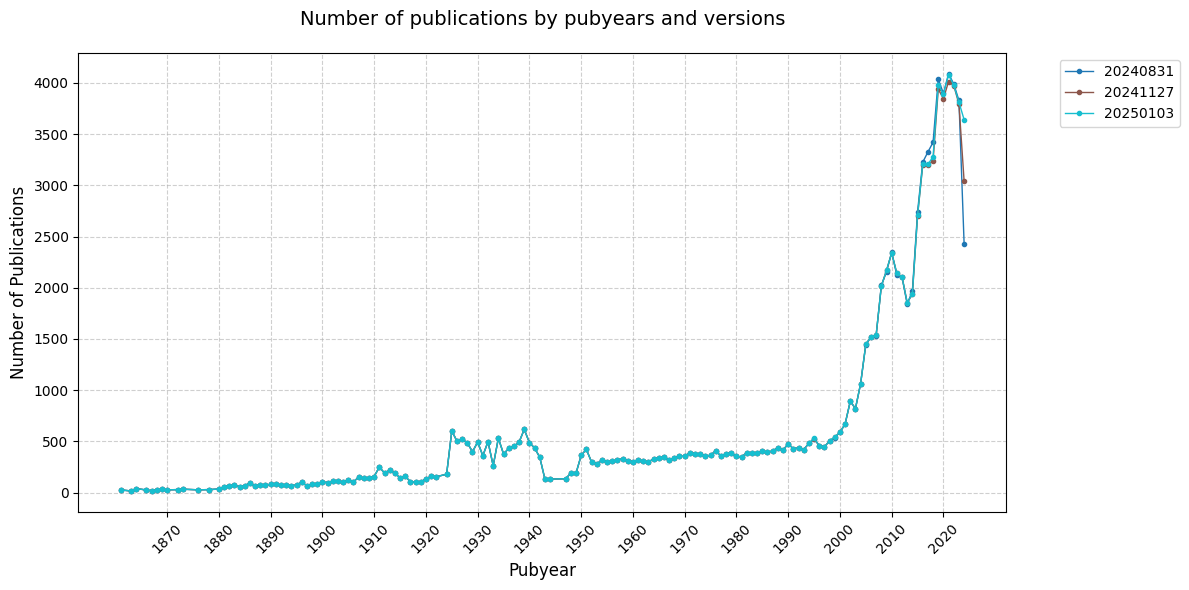

In [44]:
df = pd.read_sql(f'select version, pubyear, sum(num_sources_from_trivial_search) as cnt from project_rewi_openalex_stats.stats_rewi_items group by version, pubyear order by pubyear, version', engine)

df_sorted = df.sort_values('pubyear')
versions = df_sorted['version'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(versions)))

plt.figure(figsize=(12, 6))
ax = plt.gca() 

for version, color in zip(versions, colors):
    version_data = df_sorted[df_sorted['version'] == version]
    ax.plot(version_data['pubyear'],
            version_data['cnt'],
            marker='o',
            linestyle='-',
            color=color,
            label=version,
            markersize=3,
            linewidth=1)

years = df_sorted['pubyear'].unique()
selected_years = [year for year in years if year % 10 == 0]  

if len(selected_years) < 2:  
    step = max(1, len(years)//5)  
    selected_years = years[::step]

ax.set_xticks(selected_years)
ax.set_xticklabels(selected_years, rotation=45)  # Leichte Rotation für bessere Lesbarkeit

ax.set_title('Number of publications by pubyears and versions', fontsize=14, pad=20)
ax.set_xlabel('Pubyear', fontsize=12)
ax.set_ylabel('Number of Publications', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

ax.legend(bbox_to_anchor=(1.05, 1), 
         loc='upper left',
         frameon=True)

plt.tight_layout()
plt.show()

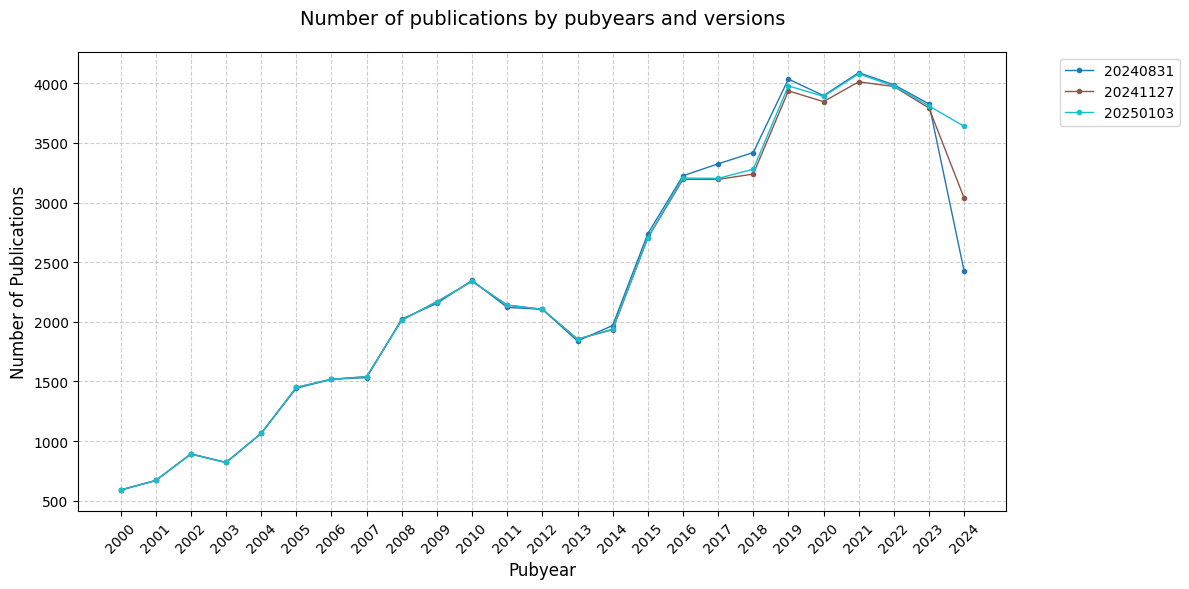

In [56]:
df = pd.read_sql(f'select version, pubyear, sum(num_sources_from_trivial_search) as cnt from project_rewi_openalex_stats.stats_rewi_items where pubyear >= 2000 group by version, pubyear order by pubyear, version', engine)

df_sorted = df.sort_values('pubyear')
versions = df_sorted['version'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(versions)))

plt.figure(figsize=(12, 6))
ax = plt.gca()

for version, color in zip(versions, colors):
    version_data = df_sorted[df_sorted['version'] == version]
    ax.plot(version_data['pubyear'],
            version_data['cnt'],
            marker='o',
            linestyle='-',
            color=color,
            label=version,
            markersize=3,
            linewidth=1)

years = df_sorted['pubyear'].unique()
selected_years = [year for year in years] 
ax.set_xticks(selected_years)
ax.set_xticklabels(selected_years, rotation=45) 

ax.set_title('Number of publications by pubyears and versions', fontsize=14, pad=20)
ax.set_xlabel('Pubyear', fontsize=12)
ax.set_ylabel('Number of Publications', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

ax.legend(bbox_to_anchor=(1.05, 1), 
         loc='upper left',
         frameon=True)

plt.tight_layout()
plt.show()

<Figure size 1000x3000 with 0 Axes>

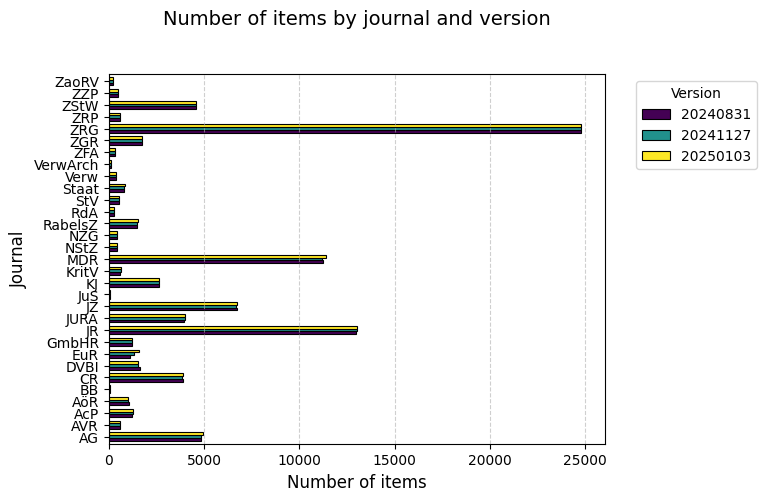

In [53]:
df = pd.read_sql(f'select version, journal, sum(num_sources_from_trivial_search)  as cnt from project_rewi_openalex_stats.stats_rewi_items group by version, journal order by journal, version', engine)

df_sorted = df.sort_values(['journal', 'version'])

pivot_df = df_sorted.pivot(index='journal',
                          columns='version',
                          values='cnt')

plt.figure(figsize=(10, 30))
ax = pivot_df.plot(kind='barh',
                  width=0.7,
                  edgecolor='black',
                  linewidth=0.8,
                  cmap='viridis')  

plt.title('Number of items by journal and version\n', 
         fontsize=14, pad=20)
plt.xlabel('Number of items', fontsize=12)
plt.ylabel('Journal', fontsize=12)

ax.xaxis.grid(True, linestyle='--', alpha=0.6) 

plt.legend(title='Version',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

plt.show()

## <a id="authors"></a> authors

    version  percent_of_items_with_authors
2  20240831                          68.91
1  20241127                          69.22
0  20250103                          69.19


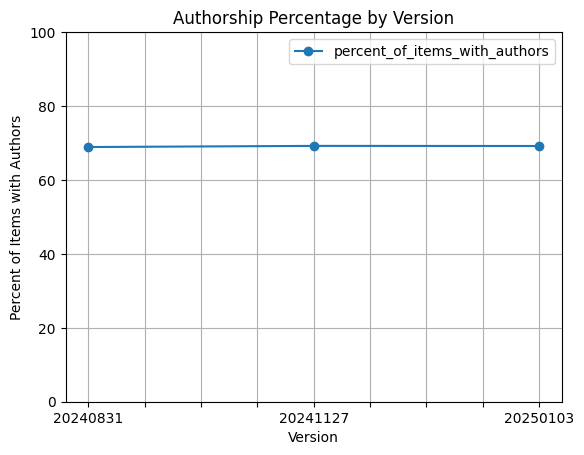

In [24]:
df = pd.read_sql(f'select * from project_rewi_openalex_stats.stats_authors', engine)

# Ensure the x-axis (version) is ordered
df['version'] = pd.Categorical(df['version'], categories=sorted(df['version']), ordered=True)
df = df.sort_values('version') 

print(df)

# Plot the data
ax = df.plot(x='version', y='percent_of_items_with_authors', kind='line', marker='o')
ax.set_ylim(0, 100)
plt.xlabel('Version')
plt.ylabel('Percent of Items with Authors')
plt.title('Authorship Percentage by Version')
plt.grid(True)
plt.show()

## <a id="references"></a> references

    version  percent_of_items_with_refs
2  20240831                        2.66
1  20241127                        2.77
0  20250103                        2.82


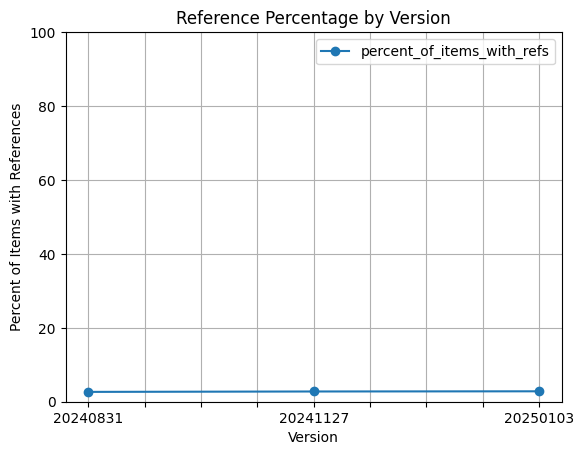

In [25]:
df = pd.read_sql(f'select * from project_rewi_openalex_stats.stats_refs', engine)

# Ensure the x-axis (version) is ordered
df['version'] = pd.Categorical(df['version'], categories=sorted(df['version']), ordered=True)
df = df.sort_values('version')  

print(df)

# Plot the data
ax = df.plot(x='version', y='percent_of_items_with_refs', kind='line', marker='o')
ax.set_ylim(0, 100)
plt.xlabel('Version')
plt.ylabel('Percent of Items with References')
plt.title('Reference Percentage by Version')
plt.grid(True)
plt.show()

<Figure size 1000x3000 with 0 Axes>

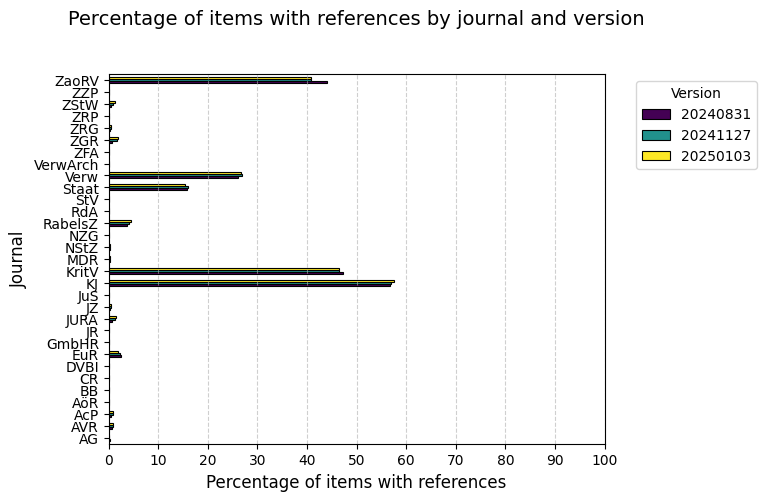

In [29]:
df = pd.read_sql(f'select * from project_rewi_openalex_stats.stats_refs_by_journal', engine)

df_sorted = df.sort_values(['journal', 'version'])

pivot_df = df_sorted.pivot(index='journal',
                          columns='version',
                          values='percent_of_items_with_refs')

plt.figure(figsize=(10, 30))
ax = pivot_df.plot(kind='barh',
                  width=0.5,
                  edgecolor='black',
                  linewidth=0.8,
                  cmap='viridis')  

plt.title('Percentage of items with references by journal and version\n', 
         fontsize=14, pad=20)
plt.xlabel('Percentage of items with references', fontsize=12)
plt.ylabel('Journal', fontsize=12)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10)) 
ax.xaxis.grid(True, linestyle='--', alpha=0.6) 

plt.legend(title='Version',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

plt.show()


## <a id="citations"></a> citations

    version  percent_of_items_with_citations
2  20240831                            17.69
1  20241127                            18.09
0  20250103                            18.17


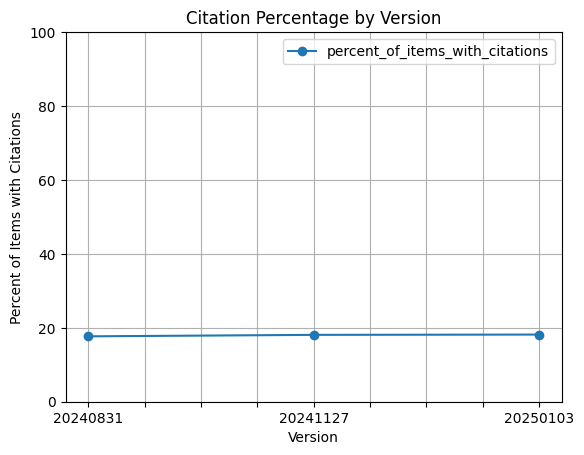

In [26]:
df = pd.read_sql(f'select * from project_rewi_openalex_stats.stats_citations', engine)

df['version'] = pd.Categorical(df['version'], categories=sorted(df['version']), ordered=True)
df = df.sort_values('version')  

print(df)

ax = df.plot(x='version', y='percent_of_items_with_citations', kind='line', marker='o')
ax.set_ylim(0, 100)
plt.xlabel('Version')
plt.ylabel('Percent of Items with Citations')
plt.title('Citation Percentage by Version')
plt.grid(True)
plt.show()

In [ ]:
df = pd.read_sql(f'select * from project_rewi_openalex_stats.stats_citations_by_journal', engine)

df_sorted = df.sort_values(['journal', 'version'])

pivot_df = df_sorted.pivot(index='journal',
                          columns='version',
                          values='percent_of_items_with_citations')

plt.figure(figsize=(10, 30))
ax = pivot_df.plot(kind='barh',
                  width=0.5,
                  edgecolor='black',
                  linewidth=0.8,
                  cmap='viridis')  

plt.title('Percentage of items with citations by journal and version\n', 
         fontsize=14, pad=20)
plt.xlabel('Percentage of items with citations', fontsize=12)
plt.ylabel('Journal', fontsize=12)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10)) 
ax.xaxis.grid(True, linestyle='--', alpha=0.6) 

plt.legend(title='Version',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

plt.show()


## <a id="affiliations"></a> affiliations

In [ ]:
df = pd.read_sql(f'select * from project_rewi_openalex_stats.stats_author_affiliations', engine)

df['version'] = pd.Categorical(df['version'], categories=sorted(df['version']), ordered=True)
df = df.sort_values('version') 

print(df)

ax = df.plot(x='version', y='percent_of_items_with_author_affiliations', kind='line', marker='o')
ax.set_ylim(0, 100)
plt.xlabel('Version')
plt.ylabel('Percent of Items with author affiliations')
plt.title('Affiliation Percentage by Version')
plt.grid(True)
plt.show()